In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
from tqdm import tqdm
import time
sys.path.append('../../../src')

import torch
import torch.nn.functional as F
from torch import tensor
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import Normalizer

from common import common, transform, json
from common.json import IA_FORMAT, START_IDX
from common.functions import gauss, cos_similarity, standardize
from common.default import PASSING_DEFAULT
from display.display import display
from individual_activity.individual_activity import IndividualActivity

In [2]:
device_idx = 2
device = f'cuda:{device_idx}' if torch.cuda.is_available() else 'cpu'
device

'cuda:2'

# Indivisual Activity をロード

In [3]:
data_settings = [
    {'room_num': '02', 'date': '20210903', 'option': 'passing'},
    {'room_num': '08', 'date': '20210915', 'option': 'passing'},
    {'room_num': '09', 'date': '20210706', 'option': 'passing'}
]

In [4]:
# homography
def get_homo(room_num):
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    p_video = common.homo[room_num][0]
    p_field = common.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)
    return homo

In [5]:
def load_individuals(json_data, prefix, homo):
    individuals = {}
    for data in json_data:
        label = prefix + str(data[IA_FORMAT[0]])
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]
        keypoints = data[IA_FORMAT[3]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        ia.keypoints[frame_num] = keypoints
        for f in IA_FORMAT[START_IDX:]:
            ia.indicator_dict[f][frame_num] = data[f]
            
    return individuals

In [6]:
individuals = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    homo = get_homo(room_num)
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    dirs = sorted(dirs)[:-1]  # delete make_csv.csv
    
    for path in tqdm(dirs):
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        prefix = path.split('/')[-6] + '_' + path.split('/')[-3] + '_'  # room-num_date_
        individuals.update(load_individuals(json_data, prefix, homo))

{'room_num': '02', 'date': '20210903', 'option': 'passing'}


100%|██████████| 23/23 [00:03<00:00,  6.25it/s]


{'room_num': '08', 'date': '20210915', 'option': 'passing'}


100%|██████████| 41/41 [00:04<00:00,  9.86it/s]


{'room_num': '09', 'date': '20210706', 'option': 'passing'}


100%|██████████| 9/9 [00:01<00:00,  5.10it/s]


# 特徴量抽出とデータ生成

In [7]:
def extract_features(frame_num, label1, label2, individuals):
    individual1 = individuals[label1]
    pos1 = individual1.get_data('position', frame_num)
    kps1 = individual1.keypoints[frame_num]
    if pos1 is None or kps1 is None:
        return None
    
    individual2 = individuals[label2]
    pos2 = individual2.get_data('position', frame_num)
    kps2 = individual2.keypoints[frame_num]
    if pos2 is None or kps2 is None:
        return None
    
    # ポジション間の距離
    norm = np.linalg.norm(np.array(pos1) - np.array(pos2), ord=2)
    if norm < 50 or 300 < norm:
        # norm が範囲外の時はデータに加えない
        # plot.ipynb の分布から決定した
        return None
    
    features = []
    for p1 in kps1:
        row = []
        for p2 in kps2:
            norm = np.linalg.norm(np.array(p1) - np.array(p2))
            row.append(norm)
        features.append(row)
    
    return features

In [8]:
x_dict = {}
y_dict = {}
for setting in data_settings:
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    dirs = sorted(glob.glob(f'{common.data_dir}/{room_num}/{date}/{opt}/*'))
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]

    for path in dirs:
        file_num = path.split('/')[-1]
        csv_path = f'{path}/csv/data.csv'
        csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

        for row in tqdm(csv_data, desc=f'{room_num}, {date}, {file_num}'):
            frame_num = row[0]
            label1 = f'{room_num}_{file_num}_{row[1]}'
            label2 = f'{room_num}_{file_num}_{row[2]}'

            features = extract_features(frame_num, label1, label2, individuals)
            key = f'{room_num}_{file_num}_{row[1]}_{row[2]}'

            if key not in x_dict:
                x_dict[key] = []
                y_dict[key] = []

            x_dict[key].append(features)
            y_dict[key].append(row[3])

09, 20210706, 09: 100%|██████████| 3701/3701 [00:04<00:00, 823.72it/s] 


## nanを穴埋めする

In [9]:
def fill_nan(x_lst, y_lst, window=3):
    # None を飛ばす
    for i in range(len(x_lst)):
        if x_lst[i] is not None:
            break
    
    pre_x = x_lst[i]
    pre_y = y_lst[i]
    
    copy_x_lst = []
    copy_y_lst = []
    for x, y in zip(x_lst[i + 1:], y_lst[i + 1:]):
        if x is not None:
            if True in np.isnan(x):
                x = np.where(np.isnan(x), pre_x, x).copy()
            copy_x_lst.append(x)
            copy_y_lst.append(y)
            pre_x = x.copy()
            pre_y = y.copy()
        else:
            # 前のフレームからコピー
            copy_x_lst.append(pre_x)
            copy_y_lst.append(pre_y)

    # 残ったnanは移動平均で穴埋め
    ma_x_lst = []
    ma_y_lst = []
    for i in range(0, len(copy_x_lst) - window + 1):
        if copy_x_lst[i] is None:
            print(copy_x_lst[i:i + window])
        means = np.nanmean(copy_x_lst[i:i + window], axis=0)
        for x, y in zip(copy_x_lst[i:i + window], copy_y_lst[i:i + window]):
            if True in np.isnan(x):
                x = np.where(np.isnan(x), means, x).copy()

            if len(ma_x_lst) <= i + window and True not in np.isnan(x):
                # nanを埋めきったデータのみ追加
                ma_x_lst.append(x)
                ma_y_lst.append(y)

    return  np.array(ma_x_lst), np.array(ma_y_lst)


x_dict_fill_nan = {}
y_dict_fill_nan = {}
for key, x_lst in x_dict.items():
    y_lst = y_dict[key]
    x_lst, y_lst = fill_nan(x_lst, y_lst, window=3)
    if len(x_lst) > 0:
        x_dict_fill_nan[key] = x_lst
        y_dict_fill_nan[key] = y_lst

/tmp/ipykernel_18702/98515819.py:31: RuntimeWarning: Mean of empty slice
  means = np.nanmean(copy_x_lst[i:i + window], axis=0)


## 標準化

In [12]:
x_all = []
for x_lst in x_dict_fill_nan.values():
    x_all += x_lst.tolist()

mean = np.mean(x_all)
std = np.std(x_all)
print(mean, std)

x_dict_std = {}
y_dict_std = y_dict_fill_nan
for key, x_lst in x_dict_fill_nan.items():
    x_lst = (np.array(x_lst) - mean) / std
    x_dict_std[key] = x_lst

318.95485068617876 161.0945804210834


# 深層学習

In [64]:
# model settings
SEQ_LEN = 16

# leraning rate
LR = 0.001

# training and data settings
EPOCH = 30
BATCH_SIZE = 128
TRAIN_RATIO = 0.7
VAL_RATIO = 0.05

config = {
    'seq_len': SEQ_LEN,
    'n_channel': 1,
    'n_convs': 2,
    'conv_hidden_dims': [128, 256],
    'conv_is_doubles': [False, True],
    'n_linears': 2,
    'hidden_dims': [512, 128],
    'dropouts': [0.1, 0],
    'n_classes': 2,
    'lr': LR,
    'epoch': EPOCH,
    'batch_size':BATCH_SIZE,
    'device': device,
}

# setting random seed
SEED = 64
np.random.seed(SEED)
torch.manual_seed(SEED)

## データセット生成

In [65]:
def create_sequence(x_lst, y_lst, seq_len, n_channel):
    x_seq = []
    y_seq = []
    for i in range(len(x_lst) - seq_len + 1):
        x_seq.append(np.array(x_lst[i:i + seq_len]).reshape(n_channel, seq_len, 17, 17))
        y_seq.append(y_lst[i + seq_len - 1])
    
    return x_seq, y_seq


class MyDataset(Dataset):
    def __init__(self, x_dict, y_dict, **kwargs):
        seq_len = kwargs['seq_len']
        n_channel = kwargs['n_channel']
        self.x, self.y = [], []
        for key in tqdm(x_dict.keys()):
            x_lst = x_dict[key]
            y_lst = y_dict[key]
            x_seq, y_seq = create_sequence(x_lst, y_lst, seq_len, n_channel)
            self.x += x_seq
            self.y += y_seq
            
        self.device = kwargs['device']
            
    def __getitem__(self, index):
        return (
            tensor(self.x[index]).float().to(self.device),
            tensor(self.y[index]).long().to(self.device)
        )

    def __len__(self):
        return len(self.x)

In [66]:
train_len = int(len(x_dict_std) * TRAIN_RATIO)
val_len = int(len(x_dict_std) * VAL_RATIO)

random_keys = np.random.choice(
    list(x_dict_std.keys()),
    size=len(x_dict_std),
    replace=False
)

train_keys = random_keys[:train_len]
val_keys = random_keys[train_len:train_len + val_len]
test_keys = random_keys[train_len + val_len:]

x_train_dict = {key: x_dict_std[key] for key in train_keys}
y_train_dict = {key: y_dict_std[key] for key in train_keys}
train_loader = DataLoader(
    MyDataset(x_train_dict, y_train_dict, **config),
    batch_size=BATCH_SIZE,
    shuffle=True
)

x_val_dict = {key: x_dict_std[key] for key in val_keys}
y_val_dict = {key: y_dict_std[key] for key in val_keys}
val_loader = DataLoader(
    MyDataset(x_val_dict, y_val_dict, **config),
    batch_size=BATCH_SIZE,
    shuffle=False
)

x_test_dict = {key: x_dict_std[key] for key in test_keys}
y_test_dict = {key: y_dict_std[key] for key in test_keys}
test_loader = DataLoader(
    MyDataset(x_test_dict, y_test_dict, **config),
    batch_size=BATCH_SIZE,
    shuffle=False
)

100%|██████████| 205/205 [00:00<00:00, 480.55it/s]


## モデル作成

In [67]:
class CNNModel(nn.Module):
    def __init__(self, **config):
        super(CNNModel, self).__init__()

        self.convs = nn.Sequential()
        for i in range(config['n_convs']):
            if i == 0:
                in_c = config['n_channel']
            else:
                in_c = config['conv_hidden_dims'][i - 1]
            out_c = config['conv_hidden_dims'][i]
            is_double = config['conv_is_doubles'][i]
            self.convs.add_module(
                f'conv{i + 1}',
                Conv3d(in_c, out_c, is_conv_double=is_double)
            )
        
        self.linears = nn.Sequential()
        for i in range(config['n_linears']):
            if i == 0:
                in_dim = 64 * config['conv_hidden_dims'][-1]
            else:
                in_dim = config['hidden_dims'][i - 1]
            out_dim = config['hidden_dims'][i]
            dropout = config['dropouts'][i]
            self.linears.add_module(
                f'fc{i + 1}',
                Linear(in_dim, out_dim, dropout)
            )

        self.output_layer = nn.Linear(config['hidden_dims'][-1], config['n_classes'])
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.linears(x)
        x = self.output_layer(x)
        x = self.softmax(x)
        
        return x
    
class Conv3d(nn.Sequential):
    def __init__(
        self, in_c, out_c,
        kernel_size=(3, 3, 3),
        stride=(1, 1, 1),
        padding=(1, 1, 1),
        is_conv_double=False,
    ):
        modules = []
        modules.append(nn.Conv3d(
            in_c, out_c,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        ))
        modules.append(nn.LeakyReLU())
        if is_conv_double:
            modules.append(nn.Conv3d(
                out_c, out_c,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
            ))
            modules.append(nn.LeakyReLU())
        modules.append(nn.MaxPool3d((2, 2, 2)))
        super(Conv3d, self).__init__(*modules)
        

class Linear(nn.Sequential):
    def __init__(self, in_dim, out_dim, dropout):
        super(Linear, self).__init__(
            nn.Linear(in_dim, out_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(out_dim),
            nn.Dropout(dropout)
        )

In [68]:
model = CNNModel(**config)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

model

CNNModel(
  (convs): Sequential(
    (conv1): Conv3d(
      (0): Conv3d(1, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Conv3d(
      (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (linears): Sequential(
    (fc1): Linear(
      (0): Linear(in_features=16384, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.1, inplace=False)
    )
    (fc2): Linear(
      (

## 学習

In [ ]:
history = dict(train=[], val=[])
for epoch in range(1, EPOCH + 1):
    ts = time.time()

    # train
    model = model.train()
    train_losses = []
    for x, y in train_loader:
        optimizer.zero_grad()
        pred = model(x)

        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # validate
    model = model.eval()
    val_losses = []
    with torch.no_grad():
        for x, y in val_loader:
            pred = model(x)
            loss = criterion(pred, y)
            val_losses.append(loss.item())

    te = time.time()
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f"Epoch[{epoch}/{EPOCH}] train loss: {train_loss:.5f}, val loss: {val_loss:.5f}, time: {te - ts:.2f}")

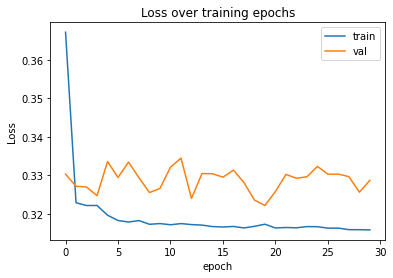

In [71]:
plt.plot(history['train'])
plt.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('Loss over training epochs')
plt.legend(['train','val'])
plt.show()

## 検証

In [85]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import warnings
warnings.simplefilter("ignore")

02_11_2_6


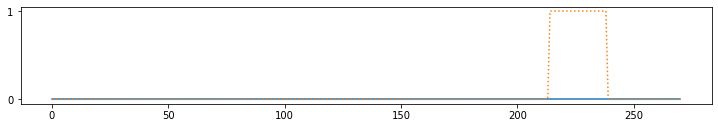

02_06_0_4


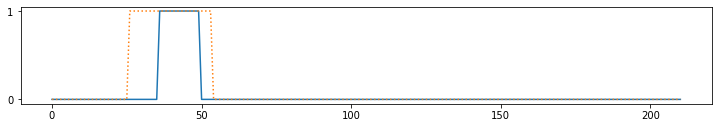

09_09_1_2


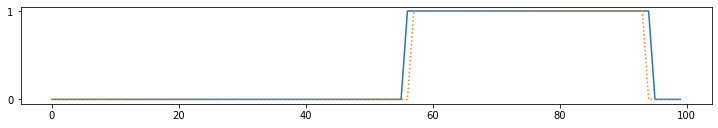

09_03_0_3


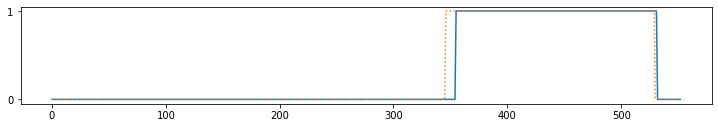

08_21_0_4


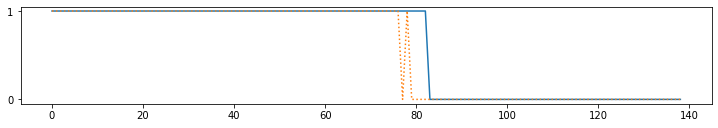

08_37_2_3


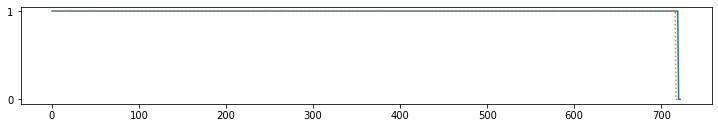

09_01_0_5


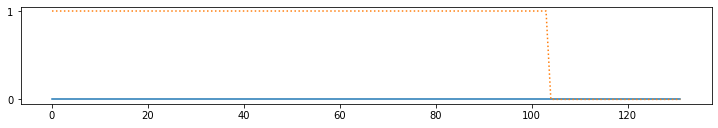

09_06_0_2


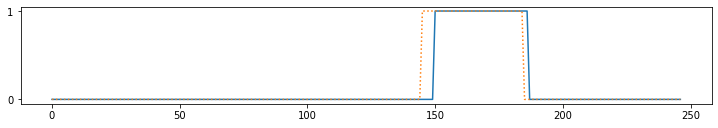

09_02_5_7


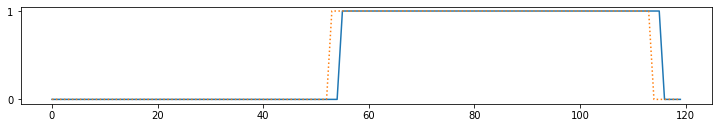

08_19_1_2


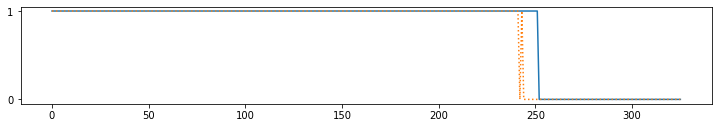

02_03_1_4


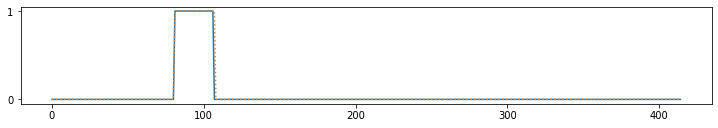

09_04_1_3


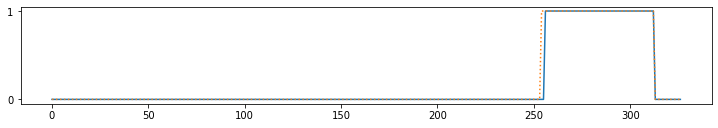

02_10_4_13


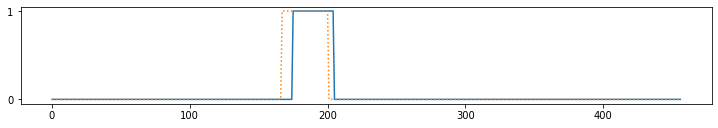

In [89]:
acc_train = []
prcs_train = []
rcl_train = []
f1_train =[]

model.eval()
with torch.no_grad():
    for key in train_keys:
        x_lst = x_dict_std[key]
        y_lst = y_dict_std[key]
        
        if 1 not in y_lst:
            continue

        y_lst = y_lst[SEQ_LEN - 1:]
        pred = []
        for i in range(0, len(x_lst) - SEQ_LEN + 1):
            x = x_lst[i:i + SEQ_LEN]
            x = np.array(x).reshape(config['n_channel'], config['seq_len'], 17, 17)
            x = torch.Tensor([x]).float().to(device)
            
            out = model(x)
            out = out.max(1)[1]
            out = out.cpu().numpy()[0]
            pred.append(out)
            
        acc_train.append(accuracy_score(pred, y_lst))
        prcs_train.append(precision_score(pred, y_lst))
        rcl_train.append(recall_score(pred, y_lst))
        f1_train.append(f1_score(pred, y_lst))
            
        print(key)
        plt.figure(figsize=(10, 1.5))
        # plt.rcParams["font.size"] = 20
        # plt.rcParams["font.family"] = 'Times New Roman'
        plt.plot(pred, label='pred')
        plt.plot(y_lst, linestyle=':', label='ground truth')
        plt.ylim((-0.05, 1.05))
        plt.yticks([0, 1])
        plt.subplots_adjust(left=0.04, right=1, bottom=0.1, top=1)

        plt.show()

In [90]:
print('accuracy: {:.3f}'.format(np.mean(acc_train)))
print('precision: {:.3f}'.format(np.mean(prcs_train)))
print('recall: {:.3f}'.format(np.mean(rcl_train)))
print('f1_score: {:.3f}'.format(np.mean(f1_train)))

accuracy: 0.911
precision: 0.768
recall: 0.817
f1_score: 0.785


09_07_1_3


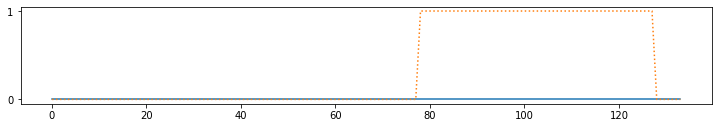

08_01_3_6


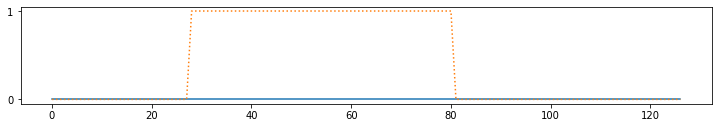

08_05_1_2


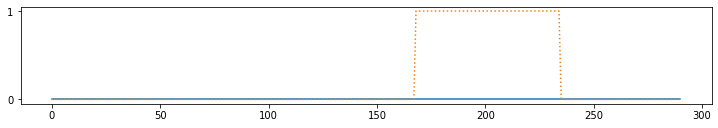

02_01_4_17


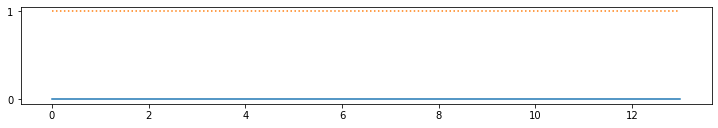

02_02_1_2


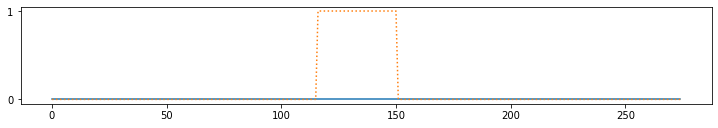

02_02_2_4


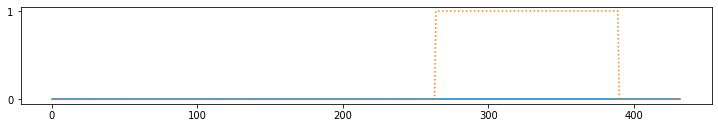

In [91]:
acc_test = []
prcs_test = []
rcl_test = []
f1_test =[]

model.eval()
with torch.no_grad():
    for key in test_keys:
        x_lst = x_dict_std[key]
        y_lst = y_dict_std[key]
        
        if 1 not in y_lst:
            continue

        y_lst = y_lst[SEQ_LEN - 1:]
        pred = []
        for i in range(0, len(x_lst) - SEQ_LEN + 1):
            x = x_lst[i:i + SEQ_LEN]
            x = np.array(x).reshape(config['n_channel'], config['seq_len'], 17, 17)
            x = torch.Tensor([x]).float().to(device)
            
            out = model(x)
            out = out.max(1)[1]
            out = out.cpu().numpy()[0]
            pred.append(out)
            
        acc_test.append(accuracy_score(pred, y_lst))
        prcs_test.append(precision_score(pred, y_lst))
        rcl_test.append(recall_score(pred, y_lst))
        f1_test.append(f1_score(pred, y_lst))
            
        print(key)
        plt.figure(figsize=(10, 1.5))
        # plt.rcParams["font.size"] = 20
        # plt.rcParams["font.family"] = 'Times New Roman'
        plt.plot(pred, label='pred')
        plt.plot(y_lst, linestyle=':', label='ground truth')
        plt.ylim((-0.05, 1.05))
        plt.yticks([0, 1])
        plt.subplots_adjust(left=0.04, right=1, bottom=0.1, top=1)

        plt.show()

In [92]:
print('accuracy: {:.3f}'.format(np.mean(acc_test)))
print('precision: {:.3f}'.format(np.mean(prcs_test)))
print('recall: {:.3f}'.format(np.mean(rcl_test)))
print('f1_score: {:.3f}'.format(np.mean(f1_test)))

accuracy: 0.594
precision: 0.000
recall: 0.000
f1_score: 0.000


In [73]:
path = f'{common.root}/model/pass_model_cnn.pth'
torch.save(model, path)